Размер обучающей выборки: (34129, 11)
Размер тестовой выборки: (1200, 5)


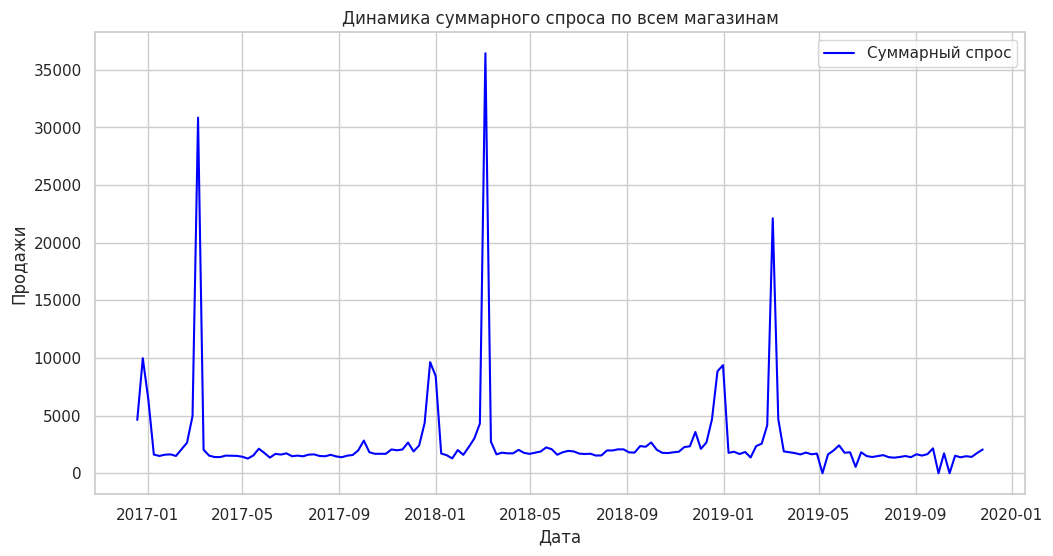

Сезонность:
На графике видна четкая сезонность и пики.
Это подтверждает необходимость использования календарных признаков.


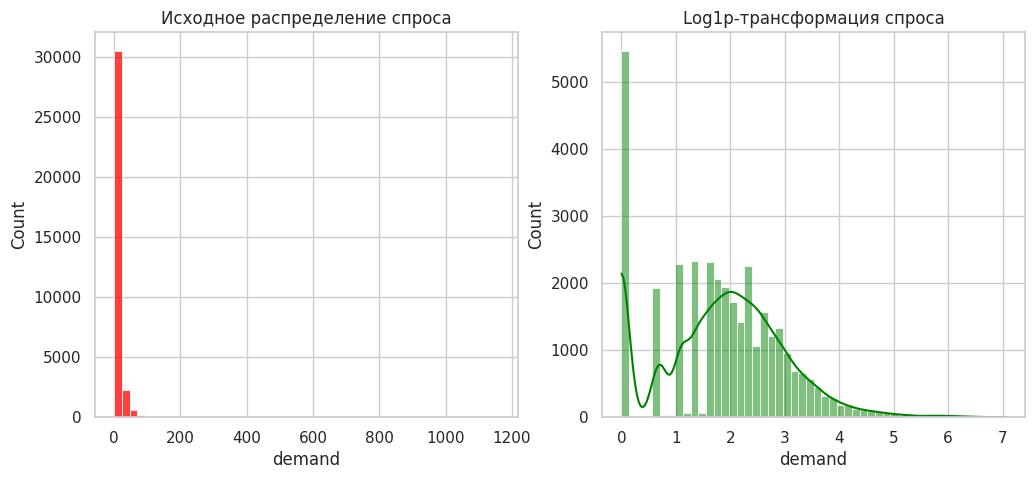

Распределение:
Исходные данные имеют много нулей.
Log-трансформация справа делает распределение более нормальным, что улучшает сходимость градиентного бустинга.
Поэтому будем обучать модель на np.log1p.
Эвристика нулей:
Если на прошлой неделе спрос был 0, вероятность нуля на следующей неделе составляет: 62.9%
Это очень высокий показатель. Мы используем это знание в пост-процессинге:
Если модель сомневается (прогноз < 1.5) и до этого был 0, мы принудительно ставим 0.
Размер данных для обучения: (33169, 13)


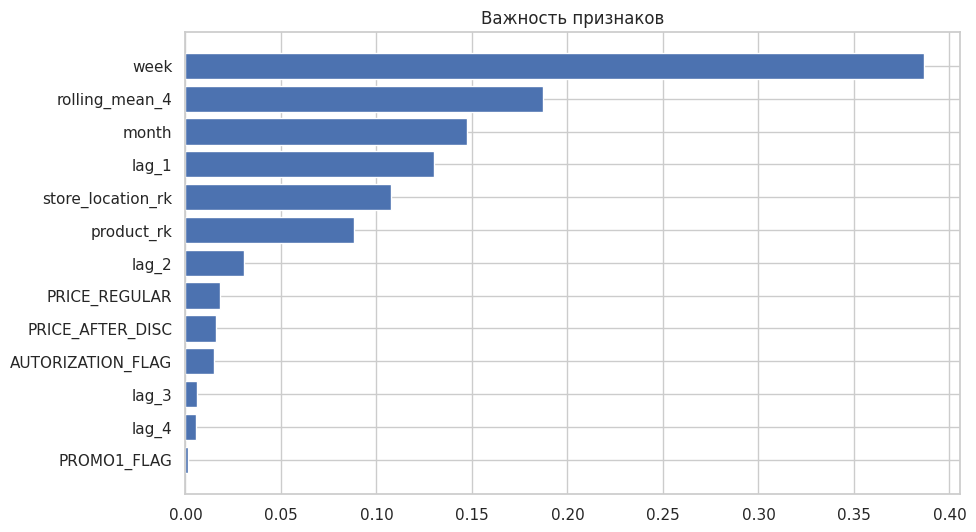

Важность признаков:
Как видно на графике, лаги  являются самыми сильными предикторами.
Это подтверждает, что лучший предсказатель будущего спроса — это недавний прошлый спрос.
Даты прогноза: ['2019-12-02', '2019-12-09', '2019-12-16', '2019-12-23', '2019-12-30']


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
import warnings

# Настройки стиля для графиков
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

# Фильтрация теста
required_ids = set(sample_sub['id'])
test = test[test['id'].isin(required_ids)].copy()


train['period_start_dt'] = pd.to_datetime(train['period_start_dt'])
test['period_start_dt'] = pd.to_datetime(test['period_start_dt'], dayfirst=True)

# Очистка трейна
train = train[train['store_location_rk'] != 309]
train = train.dropna(subset=['demand'])

print(f"Размер обучающей выборки: {train.shape}")
print(f"Размер тестовой выборки: {test.shape}")



# ГРАФИК 1: Общая динамика продаж
plt.figure()
daily_demand = train.groupby('period_start_dt')['demand'].sum()
plt.plot(daily_demand.index, daily_demand.values, label='Суммарный спрос', color='blue')
plt.title('Динамика суммарного спроса по всем магазинам')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.show()

print("Сезонность:")
print("На графике видна четкая сезонность и пики.")
print("Это подтверждает необходимость использования календарных признаков.")

# ГРАФИК 2: Распределение целевой переменной
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train['demand'], bins=50, kde=False, color='red')
plt.title('Исходное распределение спроса')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train['demand']), bins=50, kde=True, color='green')
plt.title('Log1p-трансформация спроса')
plt.show()

print("Распределение:")
print("Исходные данные имеют много нулей.")
print("Log-трансформация справа делает распределение более нормальным, что улучшает сходимость градиентного бустинга.")
print("Поэтому будем обучать модель на np.log1p.")

train['type'] = 'train'
test['type'] = 'test'
test['demand'] = np.nan

data = pd.concat([train, test], ignore_index=True)
data = data.sort_values(['store_location_rk', 'product_rk', 'period_start_dt'])

# Заполнение пропусков
cols_to_fix = ['PRICE_REGULAR', 'PRICE_AFTER_DISC', 'PROMO1_FLAG', 'AUTORIZATION_FLAG']
for col in cols_to_fix:
    data[col] = data.groupby(['store_location_rk', 'product_rk'])[col].ffill().bfill()

data['PROMO1_FLAG'] = data['PROMO1_FLAG'].fillna(0)
data['AUTORIZATION_FLAG'] = data['AUTORIZATION_FLAG'].fillna(1)

# Календарные фичи
data['month'] = data['period_start_dt'].dt.month
data['week'] = data['period_start_dt'].dt.isocalendar().week.astype(int)

# Кодирование
le_store = LabelEncoder()
data['store_location_rk'] = le_store.fit_transform(data['store_location_rk'])
le_prod = LabelEncoder()
data['product_rk'] = le_prod.fit_transform(data['product_rk'])

# Функция создания лагов
def make_features(df):
    lags = [1, 2, 3, 4]
    for l in lags:
        df[f'lag_{l}'] = df.groupby(['store_location_rk', 'product_rk'])['demand'].shift(l)
    df['rolling_mean_4'] = df.groupby(['store_location_rk', 'product_rk'])['demand'].transform(
        lambda x: x.shift(1).rolling(4).mean()
    )
    return df

data = make_features(data)

# Анализ "Инерции нулей"
zeros_mask = (data['lag_1'] == 0) & (data['type'] == 'train')
prob_zero_next = (data.loc[zeros_mask, 'demand'] == 0).mean()

print("Эвристика нулей:")
print(f"Если на прошлой неделе спрос был 0, вероятность нуля на следующей неделе составляет: {prob_zero_next:.1%}")
print("Это очень высокий показатель. Мы используем это знание в пост-процессинге:")
print("Если модель сомневается (прогноз < 1.5) и до этого был 0, мы принудительно ставим 0.")

features = ['store_location_rk', 'product_rk', 'month', 'week',
            'PRICE_REGULAR', 'PRICE_AFTER_DISC', 'PROMO1_FLAG', 'AUTORIZATION_FLAG',
            'lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean_4']

# Убираем первые недели, где лаги NaN
train_mask = (data['type'] == 'train') & (data['lag_4'].notnull())
X_train = data.loc[train_mask, features]
y_train = np.log1p(data.loc[train_mask, 'demand'])

print(f"Размер данных для обучения: {X_train.shape}")

model = HistGradientBoostingRegressor(
    loss='absolute_error',
    learning_rate=0.03,
    max_iter=1500,
    max_depth=8,
    l2_regularization=2.0,
    categorical_features=[0, 1],
    random_state=42
)


model.fit(X_train, y_train)

# Оценка важности признаков
subset_idx = np.random.choice(X_train.index, size=2000, replace=False)
X_subset = X_train.loc[subset_idx]
y_subset = y_train.loc[subset_idx]

result = permutation_importance(model, X_subset, y_subset, n_repeats=5, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.title("Важность признаков")
plt.show()

print("Важность признаков:")
print("Как видно на графике, лаги  являются самыми сильными предикторами.")
print("Это подтверждает, что лучший предсказатель будущего спроса — это недавний прошлый спрос.")


test_dates = sorted(data[data['type'] == 'test']['period_start_dt'].unique())
print(f"Даты прогноза: {[str(d.date()) for d in test_dates]}")

for date in test_dates:
    # 1. Пересчет признаков
    data = make_features(data)

    mask = (data['period_start_dt'] == date) & (data['type'] == 'test')
    if mask.sum() == 0: continue

    # 2. Прогноз
    preds_log = model.predict(data.loc[mask, features])
    preds = np.expm1(preds_log) # Возврат из логарифма

    # 3. Пост-процессинг
    preds = np.maximum(preds, 0)
    preds = np.round(preds)

    # Эвристика: если вчера 0 и прогноз маленький, то ставим 0
    current_lags_1 = data.loc[mask, 'lag_1']
    zero_condition = (current_lags_1 == 0) & (preds < 1.5)
    preds[zero_condition] = 0

    data.loc[mask, 'demand'] = preds

submission = data[data['type'] == 'test'][['id', 'demand']].copy()
submission = submission.rename(columns={'demand': 'predicted'})

final_sub = sample_sub[['id']].merge(submission, on='id', how='left')
final_sub['predicted'] = final_sub['predicted'].fillna(0)

filename = 'submission_final_v2.csv'
final_sub.to_csv(filename, index=False)